# Connect4 DQN model
By LaughingSkull 
as new RL agent for my game COnnect-4: https://www.laughingskull.org/Games/Connect4/Connect4.php

* 0.8.0 - start with new convolutional part<br>
    * keeping L2 regularization
* 0.9.0 - extension to shallow training
* 0.10.0 - extension to L3 training
    * NO PRUNE:
    * SHARP PRUNE
    * extend phases
        * MixedR12
        * Shallow
        * Fixed2
        * Variable23
        * Variable3

## Links, learning from
[https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html](https://docs.pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
<br>
[https://pettingzoo.farama.org/tutorials/agilerl/DQN/](https://pettingzoo.farama.org/tutorials/agilerl/DQN/)
<br>
### Other helpful links

<br>[https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967](https://medium.com/@vishwapatel214/building-a-connect-4-game-bot-with-deep-learning-models-dbcd019d8967)
<br>[https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.](https://codebox.net/pages/connect4#:~:text=This%20requires%20a%20lot%20of%20work%20up%2Dfront,possible%20action%20at%20each%20step%20is%20impractical.)
<br>[https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041](https://medium.com/advanced-machine-learning/deep-learning-meets-board-games-creating-a-connect-4-ai-using-cnns-and-vits-89c8cdab0041)
<br>[https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.](https://medium.com/@piyushkashyap045/understanding-dropout-in-deep-learning-a-guide-to-reducing-overfitting-26cbb68d5575#:~:text=Choosing%20Dropout%20Rate:%20Common%20dropout,is%20better%20for%20simpler%20models.)
<br>
[https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68](https://medium.com/oracledevs/lessons-from-alphazero-connect-four-e4a0ae82af68)
<br>
[https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html](https://docs.agilerl.com/en/latest/tutorials/pettingzoo/dqn.html)
<br>



## Import dependecies and recheck installation

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pprint;
import pandas as pd
import os
from IPython.display import display, clear_output

print("All dependencies imported successfully.")
print("torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available. Using CPU.")


All dependencies imported successfully.
torch version: 2.5.1
CUDA available: True
CUDA version: 11.8
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


## Training session name

In [2]:
TRAINING_SESSION = "L3-P1-7500-NOPRUNE"
begin_start_time = time.time()
LOG_DIR ="Logs/"
MODEL_DIR ="Models/"
PRUNE = False

In [3]:
class Connect4Env:
    ROWS = 6
    COLS = 7

    def __init__(self):
        self.reset()

    def reset(self):
        self.board = np.zeros((self.ROWS, self.COLS), dtype=int)
        self.current_player = 1
        self.done = False
        return self.get_state()

    def get_state(self):
        return self.board.copy()

    def available_actions(self):
        return [c for c in range(self.COLS) if self.board[0][c] == 0]

    def step(self, action):
        if self.done or self.board[0][action] != 0:
            return self.get_state(), -10, True  # Illegal move penalty

        # Drop piece in the selected column
        for row in reversed(range(self.ROWS)):
            if self.board[row][action] == 0:
                self.board[row][action] = self.current_player
                break

        reward = 0
        self.done, winner = self.check_game_over()
        if self.done:
            if winner == self.current_player:
                reward = 1  # Win
            elif winner == 0:
                reward = 0.5  # Draw
            else:
                reward = -1  # Loss

        self.current_player *= -1  # Switch turns
        return self.get_state(), reward, self.done

    def check_game_over(self):
        # Horizontal
        for r in range(self.ROWS):
            for c in range(self.COLS - 3):
                line = self.board[r, c:c+4]
                if abs(np.sum(line)) == 4:
                    return True, int(np.sign(np.sum(line)))

        # Vertical
        for r in range(self.ROWS - 3):
            for c in range(self.COLS):
                line = self.board[r:r+4, c]
                if abs(np.sum(line)) == 4:
                    return True, int(np.sign(np.sum(line)))

        # Diagonal /
        for r in range(3, self.ROWS):
            for c in range(self.COLS - 3):
                line = [self.board[r-i][c+i] for i in range(4)]
                if abs(np.sum(line)) == 4:
                    return True, int(np.sign(np.sum(line)))

        # Diagonal \
        for r in range(self.ROWS - 3):
            for c in range(self.COLS - 3):
                line = [self.board[r+i][c+i] for i in range(4)]
                if abs(np.sum(line)) == 4:
                    return True, int(np.sign(np.sum(line)))

        # Draw
        if not np.any(self.board == 0):
            return True, 0


        return False, None


 ## Neural Network for Q-Learning

In [4]:
class DQN(nn.Module):
    def __init__(self, input_shape=(6, 7), output_size=7):
        super(DQN, self).__init__()
        self.input_shape = input_shape
        self.output_size = output_size

        h, w = input_shape
        padding = 1  # consistent padding

        # Convolutional layers with BatchNorm
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=4, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  
            nn.Flatten()
        )


        # Estimate output size after conv+pool for FC input
        dummy_input = torch.zeros(1, 1, *input_shape)
        with torch.no_grad():
            conv_out_size = self.conv(dummy_input).shape[1]

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Shape: (batch, 1, 6, 7)
        x = self.conv(x)
        return self.fc(x)


In [5]:
_model = DQN()
summary(_model, input_size=(1, 6, 7))  # batch height, width

Layer (type:depth-idx)                   Output Shape              Param #
DQN                                      [1, 7]                    --
├─Sequential: 1-1                        [1, 576]                  --
│    └─Conv2d: 2-1                       [1, 64, 7, 8]             320
│    └─ReLU: 2-2                         [1, 64, 7, 8]             --
│    └─Conv2d: 2-3                       [1, 64, 7, 8]             36,928
│    └─ReLU: 2-4                         [1, 64, 7, 8]             --
│    └─Conv2d: 2-5                       [1, 64, 6, 7]             65,600
│    └─ReLU: 2-6                         [1, 64, 6, 7]             --
│    └─MaxPool2d: 2-7                    [1, 64, 3, 3]             --
│    └─Flatten: 2-8                      [1, 576]                  --
├─Sequential: 1-2                        [1, 7]                    --
│    └─Linear: 2-9                       [1, 256]                  147,712
│    └─LayerNorm: 2-10                   [1, 256]                  512


## Replay Memory

In [6]:
class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    def clear(self):
        self.memory.clear()

    def prune(self, fraction=0.8):
        if fraction > 1.0: return
        prune_size = int(len(self.memory) * fraction)
        if prune_size == 0: return
        # Keep the most recent (len - prune_size) experiences
        self.memory = deque(list(self.memory)[prune_size:], maxlen=self.memory.maxlen)


## DQN Agent

In [7]:
class DQNAgent:
    def __init__(self, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.999, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = DQN().to(self.device)
        self.target_model = DQN().to(self.device)
        self.update_target_model()

        self.memory = ReplayMemory()
        #self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-5) #L2 regularization
        self.loss_fn = nn.MSELoss()

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state, valid_actions, player, depth, strategy_weights=None):
        board = np.array(state)

        # exploration: random or lookahead actions
        if random.random() < self.epsilon:

            # Default to random if weights are not provided
            if strategy_weights is None:
                strategy_weights = [1, 0, 0, 0, 0, 0]  # random
            
            choice = random.choices([0, 1, 2, 3, 4, 5], weights=strategy_weights)[0]
                
            if choice == 0:
                return random.choice(valid_actions)
            elif choice == 1:
                return n_step_lookahead(board, player=player, depth=1) # L-1
            elif choice == 2:
                return n_step_lookahead(board, player=player, depth=3) # L-3
            elif choice == 3:
                return n_step_lookahead(board, player=player, depth=5) # L-5
            elif choice == 4:
                return n_step_lookahead(board, player=player, depth=max(1, depth - 1)) # N-1
            elif choice == 5:
                return n_step_lookahead(board, player=player, depth=depth) # N
                
        # exploatation: from replay
        state_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
     
        with torch.no_grad():
            q_values = self.model(state_tensor).cpu().numpy()[0]

        # Mask invalid actions
        masked_q = np.full_like(q_values, -np.inf)
        for a in valid_actions:
            masked_q[a] = q_values[a]

        return int(np.argmax(masked_q))

    def remember(self, s, a, r, s2, done):
        self.memory.push(s, a, r, s2, done)

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        batch = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32, device=self.device)
        actions = torch.tensor(actions, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=self.device)
        dones = torch.tensor(dones, dtype=torch.bool, device=self.device)

        q_values = self.model(states)

        # Double DQN: use model to select next actions, target_model to evaluate
        next_actions = self.model(next_states).argmax(dim=1, keepdim=True)
        next_q_values = self.target_model(next_states).gather(1, next_actions).squeeze()

        # Compute targets
        q_targets = q_values.clone()
        for i in range(len(batch)):
            q_targets[i][actions[i]] = rewards[i] + (0 if dones[i] else self.gamma * next_q_values[i])

        loss = self.loss_fn(q_values, q_targets)

        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## N-step lookahead, ported from JS

In [8]:
def get_legal_moves(board):
    return [c for c in range(7) if board[0][c] == 0]

def drop_piece(board, col, player):
    new_board = board.copy()
    for row in reversed(range(6)):
        if new_board[row][col] == 0:
            new_board[row][col] = player
            break
    return new_board

def board_to_patterns(board, players):
    patterns = []
    # Horizontal
    for r in range(6):
        for c in range(4):
            window = board[r, c:c+4]
            if any(val in players for val in window):
                patterns.append(window)
    # Vertical
    for r in range(3):
        for c in range(7):
            window = board[r:r+4, c]
            if any(val in players for val in window):
                patterns.append(window)
    # Diagonal \
    for r in range(3):
        for c in range(4):
            window = np.array([board[r+i][c+i] for i in range(4)])
            if any(val in players for val in window):
                patterns.append(window)
    # Diagonal /
    for r in range(3):
        for c in range(3, 7):
            window = np.array([board[r+i][c-i] for i in range(4)])
            if any(val in players for val in window):
                patterns.append(window)
    return patterns

def count_windows_in_pattern(patterns, count, player):
    return sum(1 for w in patterns if np.count_nonzero(w == player) == count and np.count_nonzero(w == 0) == 4 - count)

def get_heuristic(board, player):
    opponent = -player
    patterns = board_to_patterns(board, [player, opponent])
    score = 0
    weights = {2: 10, 3: 100, 4: 1000}
    for n in [2, 3, 4]:
        my_count = count_windows_in_pattern(patterns, n, player)
        opp_count = count_windows_in_pattern(patterns, n, opponent)
        score += weights[n] * (my_count - 1.5 * opp_count)
    return score

def is_terminal_node(board):
    patterns = board_to_patterns(board, [1, -1])
    return count_windows_in_pattern(patterns, 4, 1) > 0 or count_windows_in_pattern(patterns, 4, -1) > 0 or np.all(board != 0)

def minimax(board, depth, maximizing, player, alpha, beta):
    if depth == 0 or is_terminal_node(board):
        return get_heuristic(board, player)

    valid_moves = get_legal_moves(board)
    if maximizing:
        value = -np.inf
        for col in valid_moves:
            child = drop_piece(board, col, player)
            value = max(value, minimax(child, depth - 1, False, player, alpha, beta))
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value
    else:
        value = np.inf
        opponent = -player
        for col in valid_moves:
            child = drop_piece(board, col, opponent)
            value = min(value, minimax(child, depth - 1, True, player, alpha, beta))
            beta = min(beta, value)
            if beta <= alpha:
                break
        return value

def n_step_lookahead(board, player, depth=3):
    valid_moves = get_legal_moves(board)
    scores = {}
    for move in valid_moves:
        new_board = drop_piece(board, move, player)
        score = minimax(new_board, depth - 1, False, player, -np.inf, np.inf)
        scores[move] = score

    max_score = max(scores.values())
    best_moves = [m for m, s in scores.items() if s == max_score]
    center = 3
    best_moves.sort(key=lambda x: abs(center - x))  # prefer center columns
    return best_moves[0]


## Training loop - DQN against lookahead opponent (Prophet-style)

### Training settings

In [9]:
lookahead_depth = 7  # prophet = 7

num_episodes = 7500
# num_episodes = 6000 # - shortened for debug
batch_size = 64
target_update_interval = 10
log_every_x_episode = 100

TRAINING_PHASE = {
    #--------- random to L1
    "Random": 500, 
    "Mixed": 1000, # R:L1
    "SelfPlay_Begin": 1500, 
    "Mixed2": 2000, #R: 2xL1
    "VeryShallow": 2500, # L-1
    "Fixed1": 3000, # L-1
    "SelfPlay_shallow": 3500, 
    
    #--------- L1 to L2
    "Mixed R12": 4000, # R l1 l2
    "Shallow": 4500, #RND(1,2)
    "SelfPlay_shallow2": 5000,
    
    #--------- L2
    "Fixed2": 5500, #500 L-2
    "SelfPlay_L2": 6000, 

    #--------- L2, L1 to L3
    "Variable23": 6500,  #RND(2,3)
    "Variable3": 7000,  #RND(1,3)
    "SelfPlay_L3": 7500, 
    
    #---------
    # "Fixed3": 7500, #l-3
    # "Variable34": 8500 # RND(3,4)
    # "Fixed4": 9000, #L-4
    # "Variable35": 9500,  RND(3,5)
    # "SelfPlay_L4": 10000, 

    #---------
    #"Full": 10000, #500 L-N
    #---------
    
    "Final": None, #final self play
}

ACT_W = {
    # [R, L1, L3, L5, N-1, N]
    "Random": [0.75, 0.25, 0, 0, 0, 0],
    "Mixed": [0.4, 0.6, 0, 0, 0, 0],
    "SelfPlay_Begin": [],
    "Mixed2": [0.3, 0.7, 0, 0, 0, 0], 
    "VeryShallow": [0.2, 0.6, 0.2, 0, 0, 0], 
    "Fixed1": [0.0, 0.9, 0.1, 0, 0, 0], 
    "SelfPlay_shallow": [], 

    #---------
    "Mixed R12": [0.2, 0.5, 0.3, 0, 0, 0],
    "Shallow": [0.2, 0.4, 0.4, 0, 0, 0],
    "SelfPlay_shallow2": [],
    #---------
    "Fixed2": [0.2, 0.5, 0.5, 0, 0, 0],
    "SelfPlay_L2": [],
     #---------
    "Variable23": [0.15, 0.2, 0.6, 0.2, 0, 0],
    "Variable3": [0.2, 0.5, 0.5, 0, 0, 0],
    "SelfPlay_L3": [],
    #---------
    # "Fixed3": [0.1, 0.1, 0.6, 0.2, 0, 0],
    # Variable34: [0.1, 0.1, 0.5, 0.3, 0, 0],
    # "Fixed4": [0.1, 0.1, 0.4, 0.4, 0, 0],
    # "Variable35": [0.1, 0.1, 0.4, 0.4, 0, 0],
    # "SelfPlay_L4": [],
    #---------
    # "Full": [0.2, 0.1, 0.2, 0.5, 0, 0], # amend for prophet
    "Final": []
}

EPSILON_PHASE_RESET = {
    "Random": 1.0,
    "Mixed": 0.9,
    "SelfPlay_Begin": 0,
    "Mixed2": 0.5,
    "VeryShallow": 0.5,
    "Fixed1": 0.5, 
    "SelfPlay_shallow": 0,
    
    #---------
    "Mixed R12": 0.5,
    "Shallow": 0.5,
    "SelfPlay_shallow2": 0,
    #---------
    "Fixed2": 0.5,
    "SelfPlay_L2": 0,
     #---------
    "Variable23": 0.5,
    "Variable3": 0.7,
    "SelfPlay_L3": 0,
     #---------
    # "Fixed3": 0.4,
    # Variable34: 0.5,
    # "Fixed4": 0.4,
    # "Variable35": 0.3,
    # "SelfPlay_L4": 0,
    #---------
    "Final": 0.6,
}

PHASE_MEMORY_PRUNE = {
    "Random": 0.0, # buffer is empty
    "Mixed": 0.7, #0.2
    "SelfPlay_Begin": 0.5, #0.2
    "Mixed2": 0.2,
    "VeryShallow": 0.15,
    "Fixed1": 0.15,
    "SelfPlay_shallow": 0.15,
    
    #---------
    "Mixed R12": 0.1,
    "Shallow": 0.1,
    "SelfPlay_shallow2": 0.1,

    #---------
    "Fixed2": 0.1,
    "SelfPlay_L2": 0.1,
    #---------
    "Variable23": 0.1,
    "Variable3": 0.1,
    
    
    "SelfPlay_L3": 0.05,
    #---------
    # "Fixed3": 0.05,
    # Variable34: 0.0,
    # "Fixed4": 0.0,
    # "Variable35": 0.0,
    # "SelfPlay_L4": 0.0,
    #---------
    "Final": 0.0,
}


In [10]:
def get_opponent_action(env, episode, next_state, player, depth):
    valid_actions = env.available_actions()
    
    if episode < TRAINING_PHASE["Random"]:
        opp_action = random.choice(env.available_actions())
        
    elif episode < TRAINING_PHASE["Mixed"]:
        if random.randint(0,1) == 0:
            opp_action = random.choice(env.available_actions())
        else:
            opp_action = n_step_lookahead(next_state, player=-1, depth=1)

    elif episode < TRAINING_PHASE["SelfPlay_Begin"]:
        opp_action = agent.act(next_state, valid_actions, player=-1, depth=depth)

    ####################################

    elif episode < TRAINING_PHASE["Mixed2"]:
        if random.randint(0,2) == 0:
            opp_action = random.choice(env.available_actions())
        else:
            opp_action = n_step_lookahead(next_state, player=-1, depth=1)
        
    elif episode < TRAINING_PHASE["VeryShallow"]:
        opp_action = n_step_lookahead(next_state, player=-1, depth=1)

    elif episode < TRAINING_PHASE["Fixed1"]:
        opp_action = n_step_lookahead(next_state, player=-1, depth=1)

    elif episode < TRAINING_PHASE["SelfPlay_shallow"]:
        opp_action = agent.act(next_state, valid_actions, player=-1, depth=depth)

    ######################################

    elif episode < TRAINING_PHASE["Mixed R12"]:
        choice = random.randint(0,2)
        if choice == 0:
            opp_action = random.choice(env.available_actions())
        elif choice == 1:
            opp_action = n_step_lookahead(next_state, player=-1, depth=1)
        else:
            opp_action = n_step_lookahead(next_state, player=-1, depth=2)
            
    elif episode < TRAINING_PHASE["Shallow"]:
        shallow_depth = random.randint(1, 2)
        opp_action = n_step_lookahead(next_state, player=-1, depth=shallow_depth)

    elif episode < TRAINING_PHASE["SelfPlay_shallow2"]:
        opp_action = agent.act(next_state, valid_actions, player=-1, depth=depth)

     ######################################
    
    
    elif episode < TRAINING_PHASE["Fixed2"]:
        opp_action = n_step_lookahead(next_state, player=-1, depth=2)

    elif episode < TRAINING_PHASE["SelfPlay_L2"]:
        opp_action = agent.act(next_state, valid_actions, player=-1, depth=depth)


     ######################################

    elif episode < TRAINING_PHASE["Variable23"]:
        variable_depth = random.randint(2, 3)
        opp_action = n_step_lookahead(next_state, player=-1, depth=variable_depth)
        
    elif episode < TRAINING_PHASE["Variable3"]:
        variable_depth = random.randint(1, 3)
        opp_action = n_step_lookahead(next_state, player=-1, depth=variable_depth)

    
    elif episode < TRAINING_PHASE["SelfPlay_L3"]:
        opp_action = agent.act(next_state, valid_actions, player=-1, depth=depth)

   ######################################

    # elif episode < TRAINING_PHASE["Fixed3"]:
    #     opp_action = n_step_lookahead(next_state, player=-1, depth=3)

    # elif episode < TRAINING_PHASE["Variable34"]:
    #     variable_depth = random.randint(3, 4)
    #     opp_action = n_step_lookahead(next_state, player=-1, depth=variable_depth)

    # elif episode < TRAINING_PHASE["Fixed4"]:
    #     opp_action = n_step_lookahead(next_state, player=-1, depth=4) 

    # elif episode < TRAINING_PHASE["Variable35"]:
    #     variable_depth = random.randint(3, 5)
    #     opp_action = n_step_lookahead(next_state, player=-1, depth=variable_depth)

    # elif episode < TRAINING_PHASE["SelfPlay_L4"]:
    #     opp_action = agent.act(next_state, valid_actions, player=-1, depth=depth)
        

     ######################################

    
    # elif episode < TRAINING_PHASE["Full"]:
    #     #Full N -step lookahead
    #     opp_action = n_step_lookahead(next_state, player=-1, depth=depth)
    
    
    else:
        # Final self play
        opp_action = agent.act(next_state, valid_actions, player=-1, depth=depth)
       

    return opp_action


### Training loop

In [11]:
def get_phase(episode):
    for phase_name, end_episode in TRAINING_PHASE.items():
        if end_episode is None or episode < end_episode:
            return phase_name

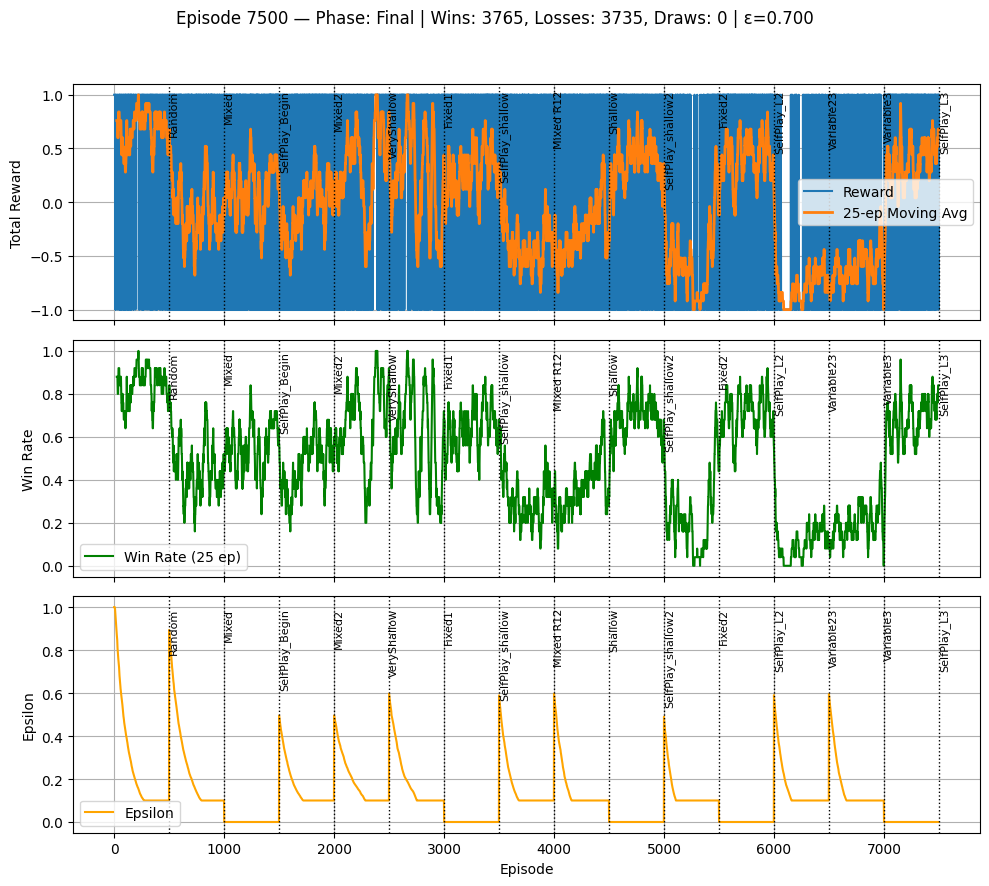

Training Episodes: 100%|█| 7500/7500 [7:21:18<00:00,  3.53s/it, avg_reward=0.68, draws=0, epsilon=0.700, losses=3735, p


Training completed in 441.3 minutes (3.53 s/episode)


In [12]:
summary_stats = {}  # store stats

SEED = 666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

env = Connect4Env()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", device)
agent = DQNAgent(device=device)

reward_history = []
win_history = []
epsilon_history = []
win_count = loss_count = draw_count = 0
phase = "Random"  
strategy_weights = []

start_time = time.time()

with tqdm(total=num_episodes, desc="Training Episodes") as pbar:
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            valid_actions = env.available_actions()
            strategy_weights = ACT_W.get(phase, [1, 1, 1, 1, 1, 1])
            action = agent.act(state, valid_actions, player=env.current_player, depth=lookahead_depth, strategy_weights=strategy_weights)

            next_state, reward, done = env.step(action)

            if not done:
                opp_action = get_opponent_action(env, episode, next_state, player=-1, depth=lookahead_depth)
                next_state, reward, done = env.step(opp_action)
                if done:
                    reward = -1

            agent.remember(state, action, reward, next_state, done)
            agent.replay(batch_size)

            state = next_state
            total_reward += reward

        epsilon_history.append(agent.epsilon)
        reward_history.append(total_reward)
        reward = round(reward, 1)

        if reward == 1:
            win_count += 1
            win_history.append(1)
        elif reward == -1:
            loss_count += 1
            win_history.append(0)
        elif reward == 0.5:
            draw_count += 1
            win_history.append(0)

        if episode % target_update_interval == 0:
            agent.update_target_model()

        new_phase = get_phase(episode)

        # phase reaction
        if new_phase != phase:
            agent.epsilon = EPSILON_PHASE_RESET.get(new_phase, agent.epsilon)
            if PRUNE:
                if PHASE_MEMORY_PRUNE.get(new_phase, False):
                    agent.memory.prune(PHASE_MEMORY_PRUNE[new_phase])


            phase = new_phase

        if episode % 10 == 0:
            avg_reward = np.mean(reward_history[-25:])
            pbar.set_postfix(avg_reward=f"{avg_reward:.2f}",
                             epsilon=f"{agent.epsilon:.3f}",
                             wins=win_count,
                             losses=loss_count,
                             draws=draw_count,
                             phase=phase)

            # Live plot
            clear_output(wait=True)
            fig, ax = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
            
            # Reward plot
            ax[0].plot(reward_history, label='Reward')
            if len(reward_history) >= 25:
                avg = np.convolve(reward_history, np.ones(25)/25, mode='valid')
                ax[0].plot(range(24, len(reward_history)), avg, label='25-ep Moving Avg', linewidth=2)
            ax[0].set_ylabel('Total Reward')
            ax[0].legend()
            ax[0].grid(True)
            
            # Win rate plot
            if len(win_history) >= 25:
                win_avg = np.convolve(win_history, np.ones(25)/25, mode='valid')
                ax[1].plot(range(24, len(win_history)), win_avg, label='Win Rate (25 ep)', color='green')
            ax[1].set_ylabel('Win Rate')
            if len(ax[1].lines) > 0:
                ax[1].legend()
            ax[1].grid(True)
            
            # Epsilon plot
            ax[2].plot(epsilon_history, label='Epsilon', color='orange')
            ax[2].set_xlabel('Episode')
            ax[2].set_ylabel('Epsilon')
            ax[2].legend()
            ax[2].grid(True)

            fig.suptitle(f"Episode {episode} — Phase: {phase} | Wins: {win_count}, Losses: {loss_count}, Draws: {draw_count} | ε={agent.epsilon:.3f}")
            plt.tight_layout(rect=[0, 0, 1, 0.95])


            # Draw vertical phase transition lines with labels
            for name, transition_ep in TRAINING_PHASE.items():
                if transition_ep is not None and transition_ep <= episode:
                    for axis in ax:
                        axis.axvline(transition_ep, color='black', linestyle='dotted', linewidth=1)
                        axis.text(transition_ep + 2, axis.get_ylim()[1]*0.95, name, rotation=90, va='top', ha='left', fontsize=8)

            
            display(fig)
            plt.close()

        # Every 50 episodes, store summary
        if episode % log_every_x_episode == 0:
            recent_rewards = reward_history[-25:] if len(reward_history) >= 25 else reward_history
            recent_win_rate = np.mean(win_history[-25:]) if len(win_history) >= 25 else np.mean(win_history)
            summary_stats[episode] = {
                "phase": phase,
                "strategy_weights": strategy_weights.copy(),
                "wins": win_count,
                "losses": loss_count,
                "draws": draw_count,
                "avg_reward_25": round(np.mean(recent_rewards), 2),
                "win_rate_25": round(recent_win_rate, 2)
            }

        pbar.update(1)

end_time = time.time()
elapsed = end_time - start_time
print(f"\nTraining completed in {elapsed/60:.1f} minutes ({elapsed / num_episodes:.2f} s/episode)")


In [13]:
print(f"\nSummary stats (every {log_every_x_episode} episodes):")
#pprint.pprint(summary_stats)
pd.DataFrame.from_dict(summary_stats, orient='index').to_excel(f"{LOG_DIR}{TRAINING_SESSION}-training_summary.xlsx", index=True)


Summary stats (every 100 episodes):


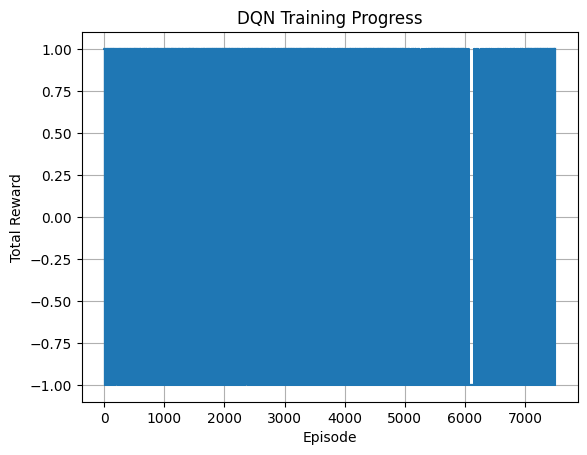

In [14]:
plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Progress")
plt.grid(True)
plt.show()

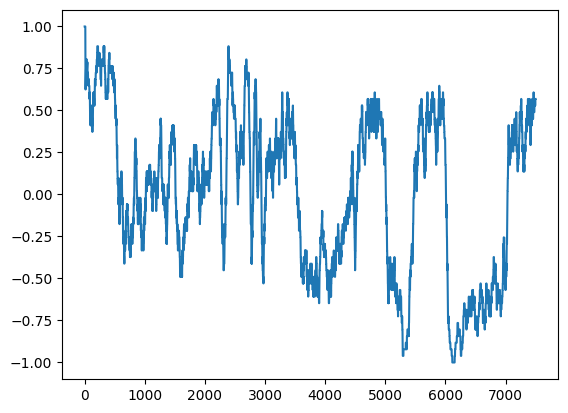

In [15]:
window = 50
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

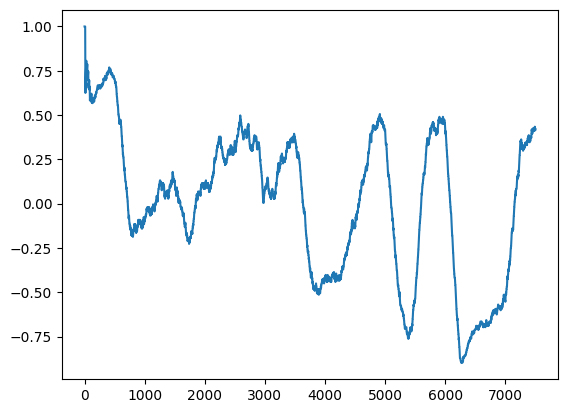

In [16]:
window = 250
smoothed = [np.mean(reward_history[max(0, i-window):i+1]) for i in range(len(reward_history))]
plt.plot(smoothed)
plt.show()

## Save model

In [17]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
model_path = f"{MODEL_DIR}{TRAINING_SESSION}_Connect4 dqn_model_{timestamp} episodes-{num_episodes} lookahead-{lookahead_depth}.pt"
default_model_path = "Connect4 DQN model.pt"

torch.save(agent.model.state_dict(), model_path)
torch.save(agent.model.state_dict(), default_model_path)
print(f"Model saved to {model_path}")


Model saved to Models/L3-P1-7500-NOPRUNE_Connect4 dqn_model_20250801-210803 episodes-7500 lookahead-7.pt


## Load model

In [18]:
agent = DQNAgent(device=device)  # Fresh agent instance
state_dict = torch.load(default_model_path, map_location=device, weights_only=True)
agent.model.load_state_dict(state_dict)
agent.update_target_model()
agent.epsilon = 0.0  # Fully greedy — no exploration
print("✅ Trained model loaded and ready for evaluation.")


✅ Trained model loaded and ready for evaluation.


# Evaluation

Opponent: Lookahead-3: 100%|███████████████████████████████████████████████████████████| 25/25 [01:05<00:00,  2.61s/it]


Evaluation completed in 2.9 minutes

📊 Evaluation Summary:
Random: 76W / 24L / 0D → Win Rate: 76.0%, Loss: 24.0%, Draws: 0.0%
Lookahead-1: 0W / 100L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%
Lookahead-2: 0W / 100L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%
Lookahead-3: 0W / 25L / 0D → Win Rate: 0.0%, Loss: 100.0%, Draws: 0.0%


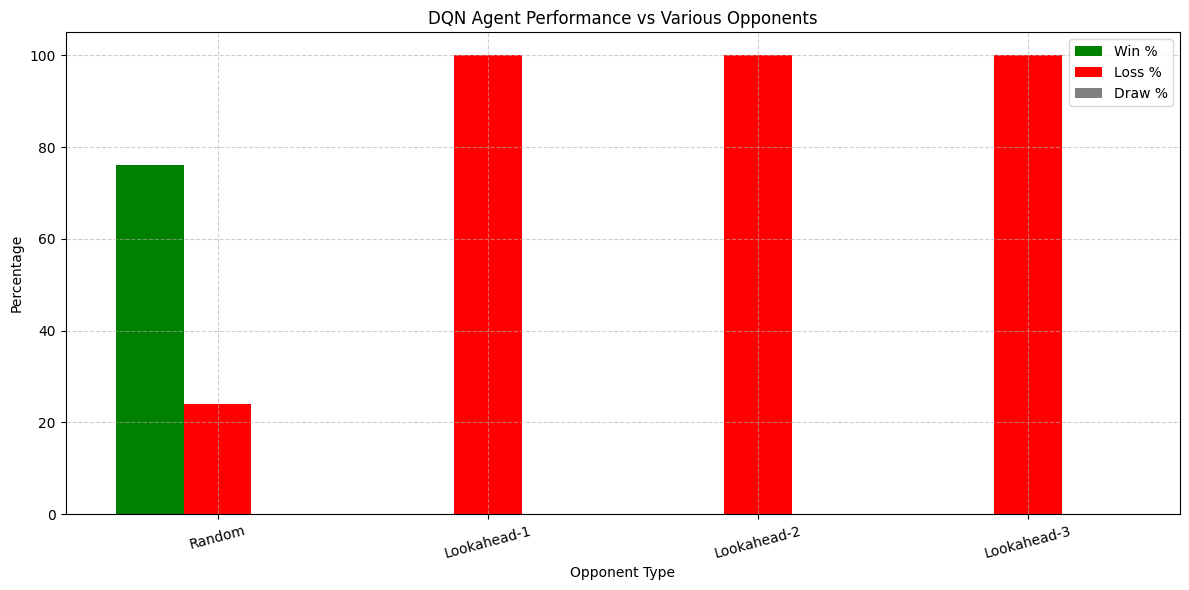

In [19]:
# === EVALUATION CONFIGURATION ===
evaluation_opponents = {
    "Random": 100,
    "Lookahead-1": 100,
    "Lookahead-2": 100,
    "Lookahead-3": 25,
    # "Lookahead-5": 10, # too soon to test
    # "Lookahead-7": 5  # too soon to test
}

# === Evaluation Loop ===
evaluation_results = {}

start_time = time.time()

for label, num_games in evaluation_opponents.items():
    wins = losses = draws = 0
    depth = int(label.split("-")[1]) if label.startswith("Lookahead") else None

    with tqdm(total=num_games, desc=f"Opponent: {label}") as pbar:
        for _ in range(num_games):
            state = env.reset()
            done = False
            agent_first = random.choice([True, False])

            while not done:
                if (env.current_player == 1 and agent_first) or (env.current_player == -1 and not agent_first):
                    valid_actions = env.available_actions()
                    action = agent.act(state, valid_actions, player=env.current_player, depth=lookahead_depth, strategy_weights=None)
                else:
                    if label == "Random":
                        action = random.choice(env.available_actions())
                    else:
                        board = np.array(state)
                        action = n_step_lookahead(board, env.current_player, depth=depth)
            
                state, reward, done = env.step(action)


            # Determine winner
            winner = -env.current_player
            if winner == 1:
                if agent_first:
                    wins += 1
                else:
                    losses += 1
            elif winner == -1:
                if not agent_first:
                    wins += 1
                else:
                    losses += 1
            else:
                draws += 1

            pbar.update(1)

    evaluation_results[label] = {
        "wins": wins,
        "losses": losses,
        "draws": draws,
        "win_rate": round(wins / num_games, 2),
        "loss_rate": round(losses / num_games, 2),
        "draw_rate": round(draws / num_games, 2)
    }


end_time = time.time()
elapsed = end_time - start_time
print(f"Evaluation completed in {elapsed/60:.1f} minutes")

# === Print Summary ===
print("\n📊 Evaluation Summary:")
for label, stats in evaluation_results.items():
    print(f"{label}: {stats['wins']}W / {stats['losses']}L / {stats['draws']}D → "
          f"Win Rate: {stats['win_rate']*100:.1f}%, Loss: {stats['loss_rate']*100:.1f}%, Draws: {stats['draw_rate']*100:.1f}%")

# === Bar Plot Summary ===
labels = list(evaluation_results.keys())
win_rates = [evaluation_results[k]['win_rate'] * 100 for k in labels]
loss_rates = [evaluation_results[k]['loss_rate'] * 100 for k in labels]
draw_rates = [evaluation_results[k]['draw_rate'] * 100 for k in labels]

x = range(len(labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x, win_rates, width=bar_width, label='Win %', color='green')
plt.bar([i + bar_width for i in x], loss_rates, width=bar_width, label='Loss %', color='red')
plt.bar([i + 2 * bar_width for i in x], draw_rates, width=bar_width, label='Draw %', color='gray')

plt.xlabel('Opponent Type')
plt.ylabel('Percentage')
plt.title('DQN Agent Performance vs Various Opponents')
plt.xticks([i + bar_width for i in x], labels, rotation=15)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Convert evaluation results to DataFrame
df_eval = pd.DataFrame.from_dict(evaluation_results, orient='index')
df_eval.index.name = "Opponent"

# Save to CSV
df_eval.to_excel(f"{LOG_DIR}{TRAINING_SESSION}-evaluation_results.xlsx", index=True)


# DONE

In [20]:
total_end_time = time.time()
total_elapsed = (total_end_time - begin_start_time) / 3600
print(f"Evaluation completed in {total_elapsed:.1f} hours")

Evaluation completed in 7.4 hours


## Training log

In [21]:
# TRAINING_SESSION

training_log_file = "training_sessions.xlsx"
log_row = {"TRAINING_SESSION": TRAINING_SESSION, "TIME [h]": total_elapsed, "EPISODES": num_episodes}

for label, stats in evaluation_results.items():
    log_row[label] = stats["win_rate"]

# === Load or Create Excel File ===
if os.path.exists(training_log_file):
    df_log = pd.read_excel(training_log_file)
else:
    df_log = pd.DataFrame()

# === Append and Save ===
df_log = pd.concat([df_log, pd.DataFrame([log_row])], ignore_index=True)
df_log.to_excel(training_log_file, index=False)

print(f"\n📁 Training session logged to: {training_log_file}")


📁 Training session logged to: training_sessions.xlsx
